In [1]:
import pandas as pd
from itertools import combinations
import itertools
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from random import randrange
import matplotlib
import seaborn as sns
from itertools import permutations
from scipy.stats import truncnorm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import os
import zipfile

# Space filling plan

- In this paper, we are using uniform projection (or Latin hypercube sampling)

In [2]:
def uniform_projection_plan(m, n):
    """
    A function for constructing a uniform projection plan for an n-dimensional hypercube 
    with m samples per dimension. 
    It returns a vector of index vectors.
    """
    perms = [np.random.permutation(m) for i in range(n)]
    return np.array([[perms[i][j] for i in range(n)] for j in range(m)])

In [3]:
def pairwise_distances(X, p=2):
    
    m = len(X)
    return [np.linalg.norm(X[i]-X[j], p) for i in range(m-1) for j in range(i+1,m)] 

def phiq(X, q=1, p=2):
    dists = pairwise_distances(X, p)
    return np.sum(np.array([(dist**(-q))**(1/q) for dist in dists]))

In [52]:
### randomly generate some sampling plans and use the one that has the smallest phiq 
m = 726
lim = 1000
n = 50
for i in range(m):
    plans = uniform_projection_plan(n, 6)
    dist = phiq(plans, q=1, p=2)
    if dist <= lim:
        lim = dist
        result = plans 

In [53]:
dist

26.829714424468715

In [105]:
n = 50
cv_lst = np.linspace(3.6, 4.1, n)
T_lst = np.linspace(25, 55, n)
# use log space because we do not want too many data points at the high values 
cc1_lst = np.logspace(-6, 1, num = n, base = 2)
cc2_lst = np.logspace(-6, 1.6, num = n, base = 2)
# ratio_lst = np.linspace(0.1, 5, n)
ocv_lst = np.linspace(0, 7, n)
n_lst = np.linspace(0, 5, n)
params = np.stack((cv_lst, T_lst, cc1_lst, cc2_lst, ocv_lst, n_lst), axis = 1)

param = params[:, 0]
index = result[:, 0]
plans = param[index][:, np.newaxis]
for i in range(1, 6):
    param = params[:, i]
    index = result[:, i]
    new = param[index][:, np.newaxis]
    plans = np.concatenate((plans, new), axis = 1)

However, for current we have to clip the values and for some variables, we don't have the bandwidth to test more values. I use the "closest" function to find values that are closes in the list that we would like to test. 

(-0.01, 3.0)

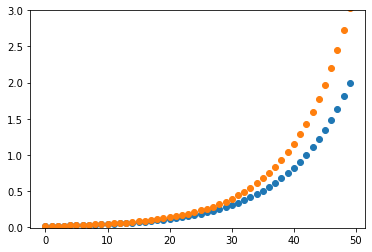

In [226]:
plt.scatter(range(n), np.logspace(-6, 1, num = n, base = 2))
plt.scatter(range(n), np.logspace(-6, 1.6, num = n, base = 2))
plt.ylim([-0.01, 3])

In [104]:
2**(-6)

0.015625

In [8]:
def closest(lst, K):   
    """
    Find the closest value in a list of current values 
    """   
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

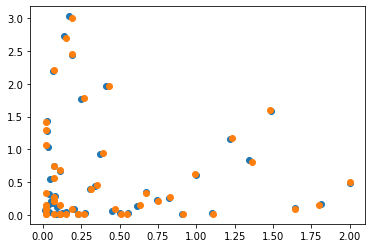

In [106]:
plt.scatter(plans[:,2], plans[:,3])
# CV list 
plans[:, 0] = [round(i,2) for i in plans[:, 0]] 
# Temperature 
plans[:, 1] = [closest([25, 35, 40, 45, 55], i) for i in plans[:, 1]] 
# you want to bound the current values, not above 2C for CC1 and 3C for CC2
plans[:, 2] = [round(closest(np.linspace(0.025, 2, n), i),2) for i in plans[:, 2]]
plans[:, 3] = [round(closest(np.linspace(0.025, 3, n), i),2) for i in plans[:, 3]]
# OCV time 
plans[:, 4] = [closest([0, 3, 7], i) for i in plans[:, 4]]  
# Verification repeats 
plans[:, 5] = [closest([0, 2, 3, 5], i) for i in plans[:, 5]]  
plt.scatter(plans[:,2], plans[:,3])

In [212]:
df_up = pd.DataFrame(plans, columns = ['formation_cutoff_voltage_1', 'formation_temperature', 'formation_charge_current_1', 
                                'formation_charge_current_2', 'ocv_time', 'formation_verification_repeat'])

### Plot two parameters at a time to check the distribution

Text(0, 0.5, 'CC$_{2}/A$')

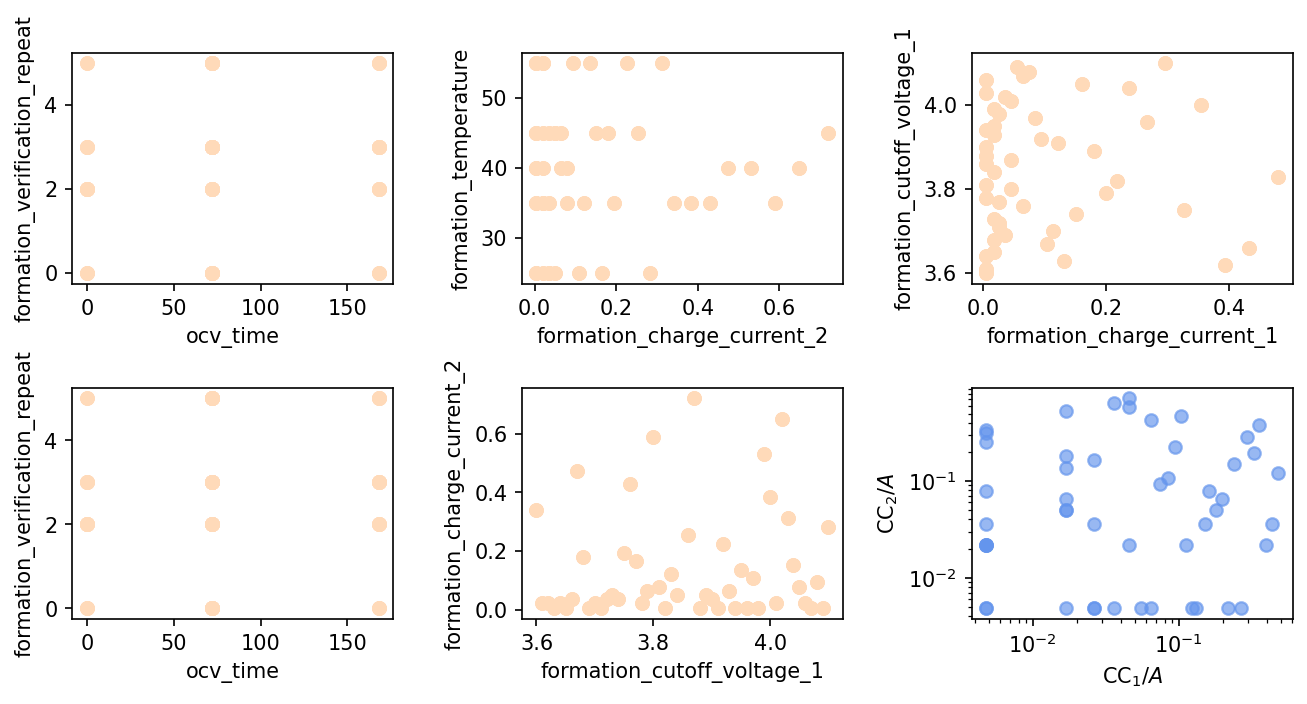

In [13]:
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3.5, num_rows*2.5), dpi = 150)

fig.subplots_adjust(hspace = .45, wspace=.4)
axs = axs.ravel()

df_up = param_df

cols = ['formation_cutoff_voltage_1', 'formation_temperature',
       'formation_charge_current_1', 'formation_charge_current_2', 'ocv_time', 'formation_verification_repeat']

# for i in range(len(cols)):
#     col = cols[i]
#     col2 = cols[len(cols)-1-i]
#     axs[i].scatter(df_up[col], df_up[col2])
#     axs[i].set_xlabel(col)
#     axs[i].set_ylabel(col2)

for i in range(5):
    cols_samp = random.sample(cols, 2)
    axs[i].scatter(df_up[cols_samp[0]], df_up[cols_samp[1]], color = 'peachpuff')
    axs[i].set_xlabel(cols_samp[0])
    axs[i].set_ylabel(cols_samp[1])
    
# axs[2].plot(df_up[cols[2]], df_up[cols[2]], linestyle = '--', color = 'orange')
axs[5].scatter(df_up[cols[2]], df_up[cols[3]], color = 'cornflowerblue', alpha = 0.3)
axs[5].set_yscale("log")
axs[5].set_xscale("log")
axs[5].set_xlabel("CC$_{1}/A$")
axs[5].set_ylabel("CC$_{2}/A$")

<AxesSubplot:>

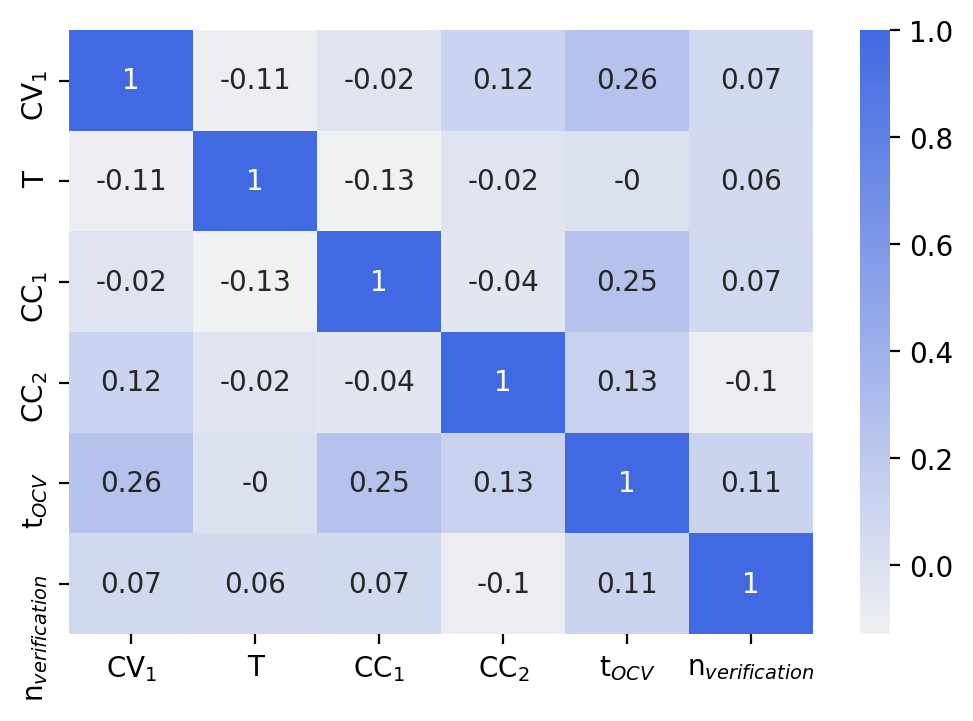

In [7]:
cols = ['formation_cutoff_voltage_1', 'formation_temperature',
       'formation_charge_current_1', 'formation_charge_current_2', 'ocv_time', 'formation_verification_repeat']
chosen = param_df[cols]
chosen.rename(columns={'formation_charge_current_1': r'CC$_1$',
       'formation_charge_current_2': r'CC$_2$', 'formation_cutoff_voltage_1':r'CV$_{1}$',
        'formation_temperature':'T', 'formation_verification_repeat':r'n$_{verification}$', 
        'ocv_time':'t$_{OCV}$'}, inplace=True)
corrMatrix = chosen.corr()
corrMatrix = round(corrMatrix, 2)
fig = plt.subplots(dpi = 200)
cmap = sns.color_palette("light:royalblue", as_cmap=True)
sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 10}, cmap = cmap)
# plt.savefig('input_correlation.png', bbox_inches='tight')

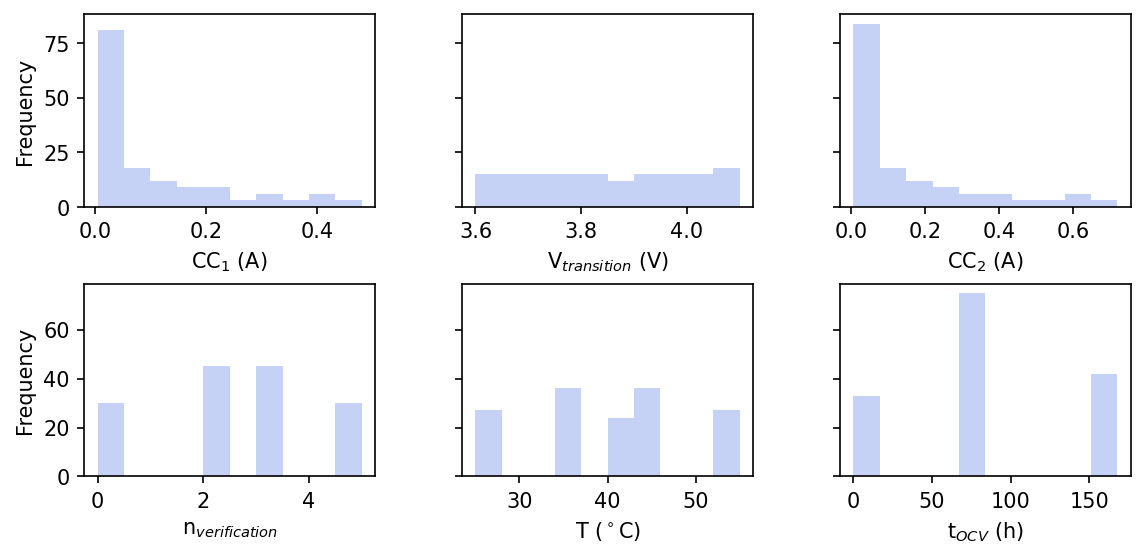

In [4]:
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*2), dpi = 150, sharey = 'row')

fig.subplots_adjust(hspace = .4, wspace=.3)
axs = axs.ravel()

df_up = param_df[['formation_charge_current_1', 'formation_cutoff_voltage_1', 
                  'formation_charge_current_2', 'formation_verification_repeat','formation_temperature',
                 'ocv_time']]

names = [  "CC$_{1}$ (A)", "V$_{transition}$ (V)", "CC$_{2}$ (A)", 'n$_{verification}$', 'T ($^\circ$C)', 't$_{OCV}$ (h)']
i = 0
for col in df_up.columns:
    df_up[col].hist(ax = axs[i], color = 'royalblue', grid = False, alpha = 0.3)
    axs[i].set_xlabel(names[i])
    if (i == 0) or (i == 3):
        axs[i].set_ylabel('Frequency')
    i += 1
    
# plt.savefig('batch_1_hist.pdf', transparent = True, bbox_inches='tight')

<AxesSubplot:>

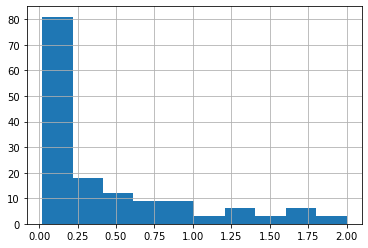

In [221]:
(df['formation_charge_current_1']/0.24).hist()

# Create the full parameter file and generate protocols 

In [186]:
df = df_up.copy()
# the wetting hold time unit is hours 
df['wetting_hold_time'] = [24]*len(df)
df['formation_cutoff_voltage_2'] = [4.4]*len(df)
# the charge hold time unit is hour
df['charge_hold_time'] = [1]*len(df)
# the unit for current is amps 
# C/5
df['formation_discharge_current'] = [0.048]*len(df)
df['formation_verification_current'] = [0.048]*len(df)
# the unit for current is amps 
df['formation_charge_current_1'] = df['formation_charge_current_1']*0.24
df['formation_charge_current_2'] = df['formation_charge_current_2']*0.24
# the unit for time is hour
df['ocv_time'] = df['ocv_time']*24
# group the values based on formation temperature to make it easy when forming the cells 
df = df.sort_values(by = 'formation_temperature').reset_index(drop = True)
# add in the repeats for the cells 
df = pd.DataFrame(np.repeat(df.values,3,axis=0), columns = df.columns)
# add in sequence number for the cells (150 cells)
df['seq_num'] = range(100, 250)
# rearrange the columns based on the order of the steps
cols = ['seq_num', 'formation_temperature', 'wetting_hold_time',  'formation_charge_current_1', 'formation_cutoff_voltage_1',
       'formation_charge_current_2',  'formation_cutoff_voltage_2', 'charge_hold_time', 'formation_discharge_current', 
        'formation_verification_current', 'formation_verification_repeat', 'ocv_time']
df = df[cols]

In [215]:
df[10:20]

,seq_num,formation_temperature,wetting_hold_time,formation_charge_current_1,formation_cutoff_voltage_1,formation_charge_current_2,formation_cutoff_voltage_2,charge_hold_time,formation_discharge_current,formation_verification_current,formation_verification_repeat,ocv_time
10,110,25.0,24.0,0.0840,3.97,0.1080,4.4,1.0,0.048,0.048,5.0,168.0
11,111,25.0,24.0,0.0840,3.97,0.1080,4.4,1.0,0.048,0.048,5.0,168.0
12,112,25.0,24.0,0.1224,3.91,0.0048,4.4,1.0,0.048,0.048,5.0,72.0
13,113,25.0,24.0,0.1224,3.91,0.0048,4.4,1.0,0.048,0.048,5.0,72.0
14,114,25.0,24.0,0.1224,3.91,0.0048,4.4,1.0,0.048,0.048,5.0,72.0
15,115,25.0,24.0,0.0264,3.72,0.0360,4.4,1.0,0.048,0.048,2.0,0.0
16,116,25.0,24.0,0.0264,3.72,0.0360,4.4,1.0,0.048,0.048,2.0,0.0
17,117,25.0,24.0,0.0264,3.72,0.0360,4.4,1.0,0.048,0.048,2.0,0.0
18,118,25.0,24.0,0.0264,3.77,0.1656,4.4,1.0,0.048,0.048,2.0,0.0
19,119,25.0,24.0,0.0264,3.77,0.1656,4.4,1.0,0.048,0.048,2.0,0.0


In [188]:
# df.to_csv('Formation_Parameters_2022.csv')